In [70]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Torch version:", torch.__version__)


CUDA available: True
CUDA version: 12.3
Torch version: 2.2.0a0+81ea7a4


In [71]:
class BalloonConfig:
    NAME = "balloon"
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 2  # Background + balloon
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    LEARNING_RATE = 0.005


In [72]:
import os
import json
import torch
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class BalloonDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        
        # Load annotations
        with open(annotation_file) as f:
            self.annotations = json.load(f)

        self.image_ids = list(self.annotations.keys())

    def __getitem__(self, idx):
        # Get the image and corresponding annotations
        image_id = self.image_ids[idx]
        annotation = self.annotations[image_id]
        
        # Load the image
        img_path = os.path.join(self.root, annotation["filename"])
        img = Image.open(img_path).convert("RGB")
        
        # Initialize mask and bounding boxes
        masks = []
        boxes = []
        
        # Process each region in the image
        for region in annotation["regions"].values():
            # Extract the polygon points
            points_x = region["shape_attributes"]["all_points_x"]
            points_y = region["shape_attributes"]["all_points_y"]
            polygon = [(x, y) for x, y in zip(points_x, points_y)]
            
            # Create mask from polygon
            mask = Image.new('L', (img.width, img.height), 0)
            ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
            mask = np.array(mask)
            
            # Append mask to list
            masks.append(mask)
            
            # Calculate bounding box for the mask
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # All balloons are class 1
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        target = {"boxes": boxes, "labels": labels, "masks": masks}
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

    def __len__(self):
        return len(self.image_ids)

# Example usage
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = BalloonDataset(root="balloon/train", annotation_file="balloon/train/via_region_data.json", transforms=transform)
val_dataset = BalloonDataset(root="balloon/val", annotation_file="balloon/val/via_region_data.json", transforms=transform)


In [74]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

def get_instance_segmentation_model(num_classes):
    # Load a pre-trained Mask RCNN model
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # Update the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    # Update the mask head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)
    
    return model

# Initialize model for 2 classes: background and balloon
model = get_instance_segmentation_model(num_classes=2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [104]:
@torch.no_grad()
def validate(model, val_loader, device):
    model.train()  # Temporarily switch to training mode to compute loss
    total_val_loss = 0
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    model.eval()  # Switch back to evaluation mode after computing loss
    return avg_val_loss  # Return the validation loss


In [105]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train_model_with_checkpointing(model, train_loader, val_loader, config, patience=5, min_delta=0.001, checkpoint_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Freeze backbone layers if training heads only
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Define optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=config.LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

    # Early stopping and checkpoint variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    num_epochs = 1000  # Set to a high number to allow indefinite running
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            total_loss += losses.item()

        # Validation after each epoch
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Early stopping and checkpointing logic
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Reset the counter if validation loss improves
            
            # Save the model checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            print(f"New best model saved with Validation Loss: {avg_val_loss:.4f}")
            
        else:
            epochs_without_improvement += 1  # Increment the counter if no improvement
            
        # Check if early stopping criterion is met
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Define DataLoaders as before
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Start training with early stopping and checkpointing
train_model_with_checkpointing(model, train_loader, val_loader, BalloonConfig())


Validation Loss: 0.3538
Epoch [1/1000], Training Loss: 0.2332, Validation Loss: 0.3538
New best model saved with Validation Loss: 0.3538


Validation Loss: 0.3344
Epoch [2/1000], Training Loss: 0.2301, Validation Loss: 0.3344
New best model saved with Validation Loss: 0.3344


Validation Loss: 0.3247
Epoch [3/1000], Training Loss: 0.2189, Validation Loss: 0.3247
New best model saved with Validation Loss: 0.3247


Validation Loss: 0.3321
Epoch [4/1000], Training Loss: 0.2084, Validation Loss: 0.3321


Validation Loss: 0.3207
Epoch [5/1000], Training Loss: 0.1877, Validation Loss: 0.3207
New best model saved with Validation Loss: 0.3207


Validation Loss: 0.3211
Epoch [6/1000], Training Loss: 0.1947, Validation Loss: 0.3211


Validation Loss: 0.3213
Epoch [7/1000], Training Loss: 0.1910, Validation Loss: 0.3213


Validation Loss: 0.3248
Epoch [8/1000], Training Loss: 0.1847, Validation Loss: 0.3248


Validation Loss: 0.3142
Epoch [9/1000], Training Loss: 0.1794, Validation Loss: 0.3142
New best model saved with Validation Loss: 0.3142


Validation Loss: 0.3260
Epoch [10/1000], Training Loss: 0.1864, Validation Loss: 0.3260


Validation Loss: 0.3395
Epoch [11/1000], Training Loss: 0.1832, Validation Loss: 0.3395


Validation Loss: 0.3261
Epoch [12/1000], Training Loss: 0.1836, Validation Loss: 0.3261


Validation Loss: 0.3239
Epoch [13/1000], Training Loss: 0.1649, Validation Loss: 0.3239


Validation Loss: 0.3352
Epoch [14/1000], Training Loss: 0.1538, Validation Loss: 0.3352
Early stopping triggered after 14 epochs.


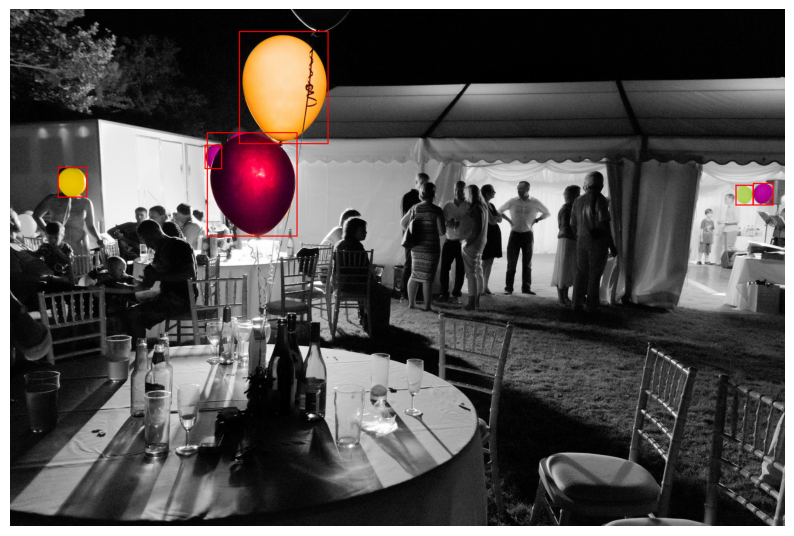

In [132]:
import skimage.color
import skimage.io
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes
import random

# Load the best model checkpoint
best_model = get_instance_segmentation_model(num_classes=2)  # Initialize a new instance of the model
best_model.load_state_dict(torch.load("best_model.pth"))  # Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)  # Move to the appropriate device
best_model.eval()  # Set the model to evaluation mode

def color_splash(image, mask):
    """Apply color splash effect to the detected objects in the image."""
    # Make a grayscale copy of the image
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    mask_combined = mask.sum(axis=0) >= 1  # Combine all masks

    # Apply color splash: keep color where mask is true, grayscale otherwise
    splash = np.where(mask_combined[..., None], image, gray).astype(np.uint8)
    return splash

# Choose a random index for the validation dataset
random_index = random.randint(0, len(val_dataset) - 1)
image, _ = val_dataset[2]  # Load a random image from the validation dataset
image_tensor = image.to(device)  # Send the image tensor to the device

# Perform inference with the best model and apply color splash
with torch.no_grad():
    predictions = best_model([image_tensor])  # Use best_model for predictions
    mask = predictions[0]["masks"] > 0.5  # Convert masks to binary
    boxes = predictions[0]["boxes"]  # Get bounding boxes
    scores = predictions[0]["scores"]  # Get confidence scores

    # Filter boxes by confidence score threshold (e.g., 0.7)
    confidence_threshold = 0.7
    keep = scores >= confidence_threshold
    boxes = boxes[keep]
    mask = mask[keep]

    # Convert the image tensor to a NumPy array for processing
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy() * 255
    image_np = image_np.astype(np.uint8)
    
    # Apply color splash effect
    splash_result = color_splash(image_np, mask.cpu().numpy())
    
    # Remove any extra dimensions from splash_result if needed
    if splash_result.ndim == 4:
        splash_result = splash_result.squeeze(0)

    # Convert the splash result back to a tensor for drawing boxes
    splash_tensor = torch.from_numpy(splash_result).permute(2, 0, 1).to(torch.uint8)

    # Draw bounding boxes on the splash image
    splash_with_boxes = draw_bounding_boxes(
        splash_tensor, 
        boxes=boxes.cpu(), 
        colors="red", 
        width=3
    )

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(splash_with_boxes.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()
